## Named-Entity Recognition Model Comparison

### Importing Requirements for data preprocessing

In [1]:
import pandas as pd
import numpy as np
from itertools import chain
import time

In [2]:
# dataset taken from `https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus`
dfRaw = pd.read_csv('./ner_dataset.csv', encoding = 'unicode_escape')

In [3]:
# first five rows
dfRaw.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [4]:
# last five rows
dfRaw.tail()

,Sentence #,Word,POS,Tag
1048570,NaN,they,PRP,O
1048571,NaN,responded,VBD,O
1048572,NaN,to,TO,O
1048573,NaN,the,DT,O
1048574,NaN,attack,NN,O


### Data Preprocessing

We assign indices to 'Word' and 'Tag' features, thus converting string to numerical data to train the model.

In [5]:
# dataset after initial pre-processing
df = dfRaw.copy()

In [6]:
# requirement for categorical encoding
from sklearn import preprocessing

In [7]:
# encoding 'Word' column
leWord = preprocessing.LabelEncoder()
leWord.fit(df['Word'])
df['WordIndx'] = leWord.transform(df['Word'])

In [8]:
# encoding 'Tag' column
leTag = preprocessing.LabelEncoder()
leTag.fit(df['Tag'])
df['TagIndx'] = leTag.transform(df['Tag'])

In [9]:
df.head()

,Sentence #,Word,POS,Tag,WordIndx,TagIndx
0,Sentence: 1,Thousands,NNS,O,15077,16
1,NaN,of,IN,O,27700,16
2,NaN,demonstrators,NNS,O,20969,16
3,NaN,have,VBP,O,24218,16
4,NaN,marched,VBN,O,26434,16


#### Further Preprocessing

In [10]:
# grouping the rows in sentences
dfNaN = df.fillna(method = 'ffill', axis = 0)
dfGrouped = dfNaN.groupby(['Sentence #'], as_index = False)[['Word', 'POS', 'Tag', 'WordIndx', 'TagIndx']].agg(lambda x : list(x))
dfGrouped = dfGrouped.sample(frac=1).reset_index(drop=True)
dfGrouped.head()

,Sentence #,Word,POS,Tag,WordIndx,TagIndx
0,Sentence: 33985,"[Mr., Chavez, used, his, Sunday, radio, and, t...","[NNP, NNP, VBD, PRP$, NNP, NN, CC, NN, NN, TO,...","[B-per, I-per, O, O, B-tim, O, O, O, O, O, O, ...","[10809, 4530, 34327, 24457, 14607, 29631, 1736...","[6, 14, 16, 16, 7, 16, 16, 16, 16, 16, 16, 6, ..."
1,Sentence: 44213,"[Tensions, rose, last, week, after, Chadian, f...","[NNS, VBD, JJ, NN, IN, JJ, NNS, VBN, IN, NNS, ...","[O, O, O, O, O, B-gpe, O, O, O, O, O, B-geo, O...","[14971, 30828, 25785, 34782, 16915, 4458, 2330...","[16, 16, 16, 16, 16, 3, 16, 16, 16, 16, 16, 2,..."
2,Sentence: 36831,"[The, conservatives, started, out, the, campai...","[DT, NNS, VBD, RP, DT, NN, IN, DT, JJ, NN, ,, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[15029, 20044, 32327, 27959, 33246, 18926, 349...","[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 1..."
3,Sentence: 3139,"[The, military, says, that, 13, other, service...","[DT, JJ, VBZ, IN, CD, JJ, NN, NNS, VBD, VBN, I...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[15029, 26776, 31036, 33242, 367, 27948, 31358...","[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 1..."
4,Sentence: 43603,"[It, says, the, two, leaders, will, also, revi...","[PRP, VBZ, DT, CD, NNS, MD, RB, VB, JJ, NNS, C...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[8298, 31036, 33246, 33885, 25852, 34920, 1728...","[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 1..."


#### Visualizing the sentence lengths

In [11]:
import matplotlib.pyplot as plt

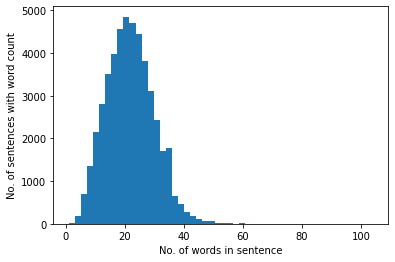

In [12]:
plt.hist([len(s) for s in dfGrouped['Word']], bins = 50)
plt.xlabel('No. of words in sentence')
plt.ylabel('No. of sentences with word count')
plt.show()

The length of sentences are ununiform therefore padding is required to make the sentence length uniform.

#### Padding the data

In [13]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [14]:
def padData(groupedData, mainData):
    
    nWord = len(list(set(mainData['Word'].to_list())))
    nTags = len(list(set(mainData['Tag'].to_list())))
    
    # Padding Words "X variables"
    wordIndx  = groupedData['WordIndx'].tolist()
    maxlen = max([len(s) for s in wordIndx])
    padWord = pad_sequences(wordIndx, maxlen = maxlen, dtype = 'int32', 
                            padding = 'post', value = 27700)
    
    
    # padding Y var
    tagIndx = groupedData['TagIndx'].tolist()
    padTags = pad_sequences(tagIndx, maxlen=maxlen, dtype='int32', padding='post', value= 16)
    
    
    # converting to binary encoded 
    n_tags = df['TagIndx'].nunique()
    padTags = [to_categorical(i, num_classes=n_tags) for i in padTags]
    
    return padWord, padTags
    

#### Test-Train-Validation Split

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
def dataSplit(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=50)
    
    return X_train, X_test, y_train, y_test

In [17]:
X, y = padData(dfGrouped, df)

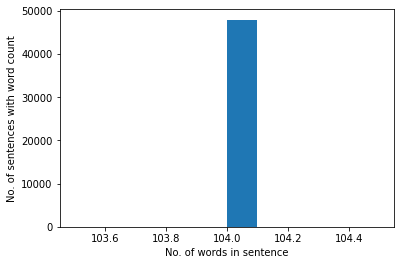

In [18]:
# Visualizing padded data
plt.hist([len(s) for s in X])
plt.xlabel('No. of words in sentence')
plt.ylabel('No. of sentences with word count')
plt.show()

After padding length of each sentence is same i.e. 104

In [19]:
X_train, X_test, y_train, y_test  = dataSplit(X, y)

### LSTM

In [20]:
!pip install livelossplot

In [21]:
from tensorflow.keras import Model,Input, Sequential
from tensorflow.keras.layers import LSTM,Embedding,Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D,Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

In [22]:
input_dim = len(list(set(df['Word'].to_list()))) + 1
output_dim = 64 # arbritrary number
input_length = max([len(s) for s in dfGrouped['WordIndx'].tolist()])
n_tags = df['TagIndx'].nunique()
print('input_dim: ', input_dim, '\noutput_dim: ', 
      output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  35179 
output_dim:  64 
input_length:  104 
n_tags:  17


In [23]:
def LstmModel():
    input_layer = Input(shape=(input_length,))
    model = Embedding(input_dim=input_dim, output_dim=output_dim, 
                      input_length=input_length)(input_layer)
    model = LSTM(units=64,return_sequences=True,recurrent_dropout=0.1)(model)
    out = TimeDistributed(Dense(n_tags,activation='softmax'))(model)
    model = Model(input_layer, out)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

In [24]:
def BiLstm():
    input_layer = Input(shape=(input_length,))
    model = Embedding(input_dim=input_dim, output_dim=output_dim, 
                      input_length=input_length)(input_layer)
    model = LSTM(units=64,return_sequences=True,recurrent_dropout=0.1)(model)
    model = Bidirectional(LSTM(units=64,return_sequences=True,recurrent_dropout=0.1))(model)
    out = TimeDistributed(Dense(n_tags,activation='softmax'))(model)
    model = Model(input_layer, out)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model
    

In [25]:
LSTMmodel = LstmModel()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 104)]             0         
                                                                 
 embedding (Embedding)       (None, 104, 64)           2251456   
                                                                 
 lstm (LSTM)                 (None, 104, 64)           33024     
                                                                 
 time_distributed (TimeDistr  (None, 104, 17)          1105      
 ibuted)                                                         
                                                                 
Total params: 2,285,585
Trainable params: 2,285,585
Non-trainable params: 0
_________________________________________________________________


In [26]:
BiLSTMmodel = BiLstm()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 104)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 104, 64)           2251456   
                                                                 
 lstm_1 (LSTM)               (None, 104, 64)           33024     
                                                                 
 bidirectional (Bidirectiona  (None, 104, 128)         66048     
 l)                                                              
                                                                 
 time_distributed_1 (TimeDis  (None, 104, 17)          2193      
 tributed)                                                       
                                                                 
Total params: 2,352,721
Trainable params: 2,352,721
Non-tra

### CRF

In [27]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-gvupemft
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-gvupemft


In [28]:
!pip install tensorflow-addons

In [29]:
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_accuracy

In [30]:
from tensorflow_addons.layers import CRF as crf
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow_addons import metrics

In [31]:
def Crf():
  input_layer = Input(shape=(input_length,))
  model = Embedding(input_dim=input_dim, output_dim=output_dim, 
                      input_length=input_length)(input_layer)
  model = Dense(64,activation='softmax')(model)
  model = Dense(n_tags,activation='softmax')(model)
  crf_layer = crf(n_tags)
  _, out, _, _ = crf_layer(model)
  model = Model(input_layer, out)
  print(model.summary())
  model.compile(optimizer='adam', loss = SigmoidFocalCrossEntropy(), 
                metrics = ['accuracy'])

  return model

In [32]:
def LSTM_CRF():
  input_layer = Input(shape=(input_length,))
  model = Embedding(input_dim=input_dim, output_dim=output_dim, 
                      input_length=input_length)(input_layer)
  model = LSTM(units=64,return_sequences=True,recurrent_dropout=0.1)(model)
  model = TimeDistributed(Dense(n_tags,activation='relu'))(model)
  crf_layer = crf(n_tags)
  _, out, _, _ = crf_layer(model)
  model = Model(input_layer, out)
  print(model.summary())
  model.compile(optimizer='adam', loss = SigmoidFocalCrossEntropy(), 
                metrics = ['accuracy'])

  return model

In [33]:
def BiLSTM_CRF():
  input_layer = Input(shape=(input_length,))
  model = Embedding(input_dim=input_dim, output_dim=output_dim, 
                      input_length=input_length)(input_layer)
  model = LSTM(units=64,return_sequences=True,recurrent_dropout=0.1)(model)
  model = Bidirectional(LSTM(units=64,return_sequences=True,
                             recurrent_dropout=0.1))(model)
  model = TimeDistributed(Dense(n_tags,activation='relu'))(model)
  crf_layer = crf(n_tags)
  _, out, _, _ = crf_layer(model)
  model = Model(input_layer, out)
  print(model.summary())
  model.compile(optimizer='adam', loss = SigmoidFocalCrossEntropy(), 
                metrics = ['accuracy'])

  return model

In [34]:
crf_model = Crf()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 104)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 104, 64)           2251456   
                                                                 
 dense_2 (Dense)             (None, 104, 64)           4160      
                                                                 
 dense_3 (Dense)             (None, 104, 17)           1105      
                                                                 
 crf (CRF)                   [(None, 104),             629       
                              (None, 104, 17),                   
                              (None,),                           
                              (17, 17)]                          
                                                           

In [35]:
crf_lstm = LSTM_CRF()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 104)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 104, 64)           2251456   
                                                                 
 lstm_3 (LSTM)               (None, 104, 64)           33024     
                                                                 
 time_distributed_2 (TimeDis  (None, 104, 17)          1105      
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 [(None, 104),             629       
                              (None, 104, 17),                   
                              (None,),                           
                              (17, 17)]                    

In [36]:
crf_BiLstm = BiLSTM_CRF()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 104)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 104, 64)           2251456   
                                                                 
 lstm_4 (LSTM)               (None, 104, 64)           33024     
                                                                 
 bidirectional_1 (Bidirectio  (None, 104, 128)         66048     
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 104, 17)          2193      
 tributed)                                                       
                                                                 
 crf_2 (CRF)                 [(None, 104),             629 

### Training and Evaluation

In [37]:
def train_model(X, y, model, numEpoch, nameFile):
    early_stopping = EarlyStopping(monitor='val_accuracy',
                                   patience=5, verbose=0, mode='max',
                                   restore_best_weights= False)
    callbacks = [PlotLossesCallback(),early_stopping]
    start_time = time.time()
    hist = model.fit(X, np.array(y), batch_size=50, verbose=1, epochs=numEpoch, validation_split=0.2, 
                    callbacks = callbacks)
    training_time = start_time - time.time()
    model.save(nameFile + '.h5')
    return hist.history['loss'], hist.history['accuracy'], training_time

In [38]:
def evaluate_model(model, X_test, y_test):
  strat_time = time.time()
  acc = model.evaluate(X_test, np.array(y_test))
  eval_time = start_time - time.time()
  return acc

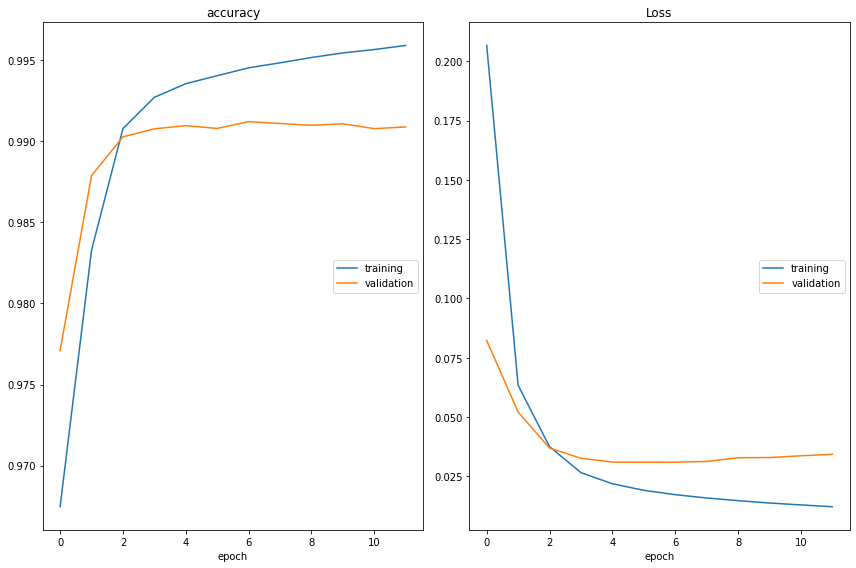

accuracy
	training         	 (min:    0.967, max:    0.996, cur:    0.996)
	validation       	 (min:    0.977, max:    0.991, cur:    0.991)
Loss
	training         	 (min:    0.012, max:    0.207, cur:    0.012)
	validation       	 (min:    0.031, max:    0.082, cur:    0.034)
614/614 [==============================] - 81s 132ms/step - loss: 0.0122 - accuracy: 0.9959 - val_loss: 0.0344 - val_accuracy: 0.9909


In [39]:
# LSTM 
lossLSTM, accLSTM, timeLstm = train_model(X_train, y_train, LSTMmodel, 50, 'LSTM')

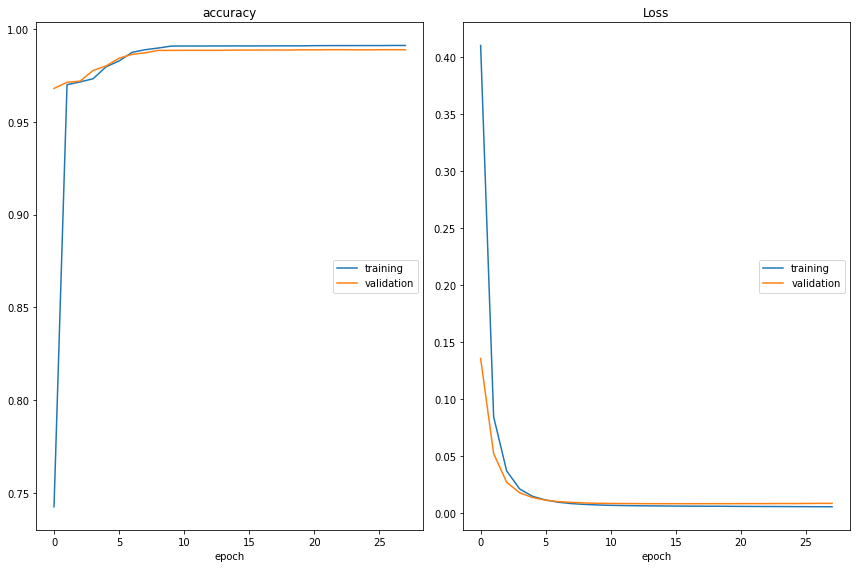

accuracy
	training         	 (min:    0.743, max:    0.991, cur:    0.991)
	validation       	 (min:    0.968, max:    0.989, cur:    0.989)
Loss
	training         	 (min:    0.006, max:    0.410, cur:    0.006)
	validation       	 (min:    0.009, max:    0.136, cur:    0.009)
614/614 [==============================] - 19s 31ms/step - loss: 0.0059 - accuracy: 0.9912 - val_loss: 0.0088 - val_accuracy: 0.9889


In [40]:
lossCRF, accuracyCRF, timeCRF = train_model(X_train, y_train, 
                                               crf_model, 50, 'Crf')

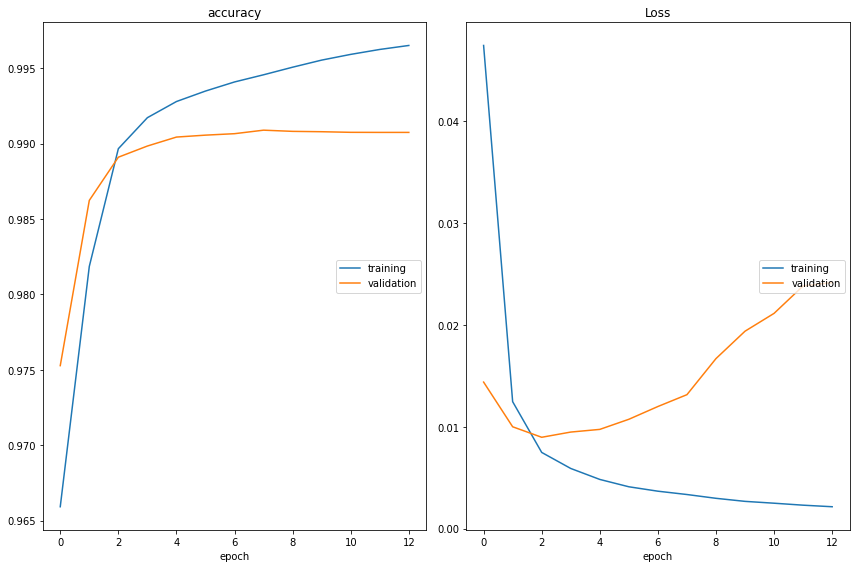

accuracy
	training         	 (min:    0.966, max:    0.996, cur:    0.996)
	validation       	 (min:    0.975, max:    0.991, cur:    0.991)
Loss
	training         	 (min:    0.002, max:    0.047, cur:    0.002)
	validation       	 (min:    0.009, max:    0.024, cur:    0.024)
614/614 [==============================] - 84s 136ms/step - loss: 0.0021 - accuracy: 0.9965 - val_loss: 0.0242 - val_accuracy: 0.9907


In [41]:
lossLCRF, accuracyLCRF, timeLCRF = train_model(X_train, y_train, 
                                               crf_lstm, 50, 'LCrf')

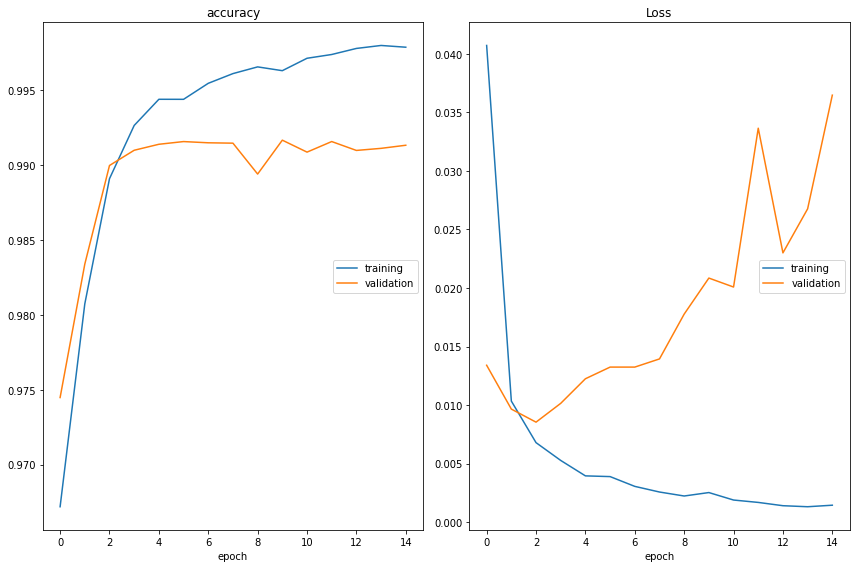

accuracy
	training         	 (min:    0.967, max:    0.998, cur:    0.998)
	validation       	 (min:    0.974, max:    0.992, cur:    0.991)
Loss
	training         	 (min:    0.001, max:    0.041, cur:    0.001)
	validation       	 (min:    0.009, max:    0.036, cur:    0.036)
614/614 [==============================] - 198s 323ms/step - loss: 0.0014 - accuracy: 0.9979 - val_loss: 0.0365 - val_accuracy: 0.9913


In [42]:
lossBLCRF, accuracyBLCRF, timeBLCRF = train_model(X_train, y_train, 
                                               crf_BiLstm, 50, 'BLCrf')

In [51]:
# tabulating the metrics
model_metrics = {'Models':['LSTM', 'CRF', 'LSTM-CRF', 'BiLSTM-CRF'], 
                 'training_loss': [0.012, 0.006, 0.002, 0.0014],
                 'training_accuracy': [0.996, 0.991, 0.996, 0.9979],
                 'validation_loss': [0.034, 0.009, 0.024, 0.0365],
                 'validation_accuracy': [0.991, 0.989, 0.991, 0.9913],
                 'training_time(seconds)': [-timeLstm, -timeCRF, -timeLCRF, -timeBLCRF]}

In [52]:
model_metrics = pd.DataFrame(model_metrics).set_index('Models')
model_metrics.head()

,training_loss,training_accuracy,validation_loss,validation_accuracy,training_time(seconds)
Models,,,,,
LSTM,0.0120,0.9960,0.0340,0.9910,968.629908
CRF,0.0060,0.9910,0.0090,0.9890,563.124631
LSTM-CRF,0.0020,0.9960,0.0240,0.9910,1089.292771
BiLSTM-CRF,0.0014,0.9979,0.0365,0.9913,2974.175978
